<div style='background-image: url("https://www.geophysik.uni-muenchen.de/ROMY/theme/images/ringlaser_wideformat.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: left ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 35% ; height: 150px">
        <div style="position: relative ; top: 50%;  transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%"> <br>ROMY - <br><br>  Synthetic Sagnac Processing </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)"></div>
        </div>
    </div>

## Import 

### Official Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import time

from scipy.signal import resample, hilbert, correlate, decimate, butter, spectrogram, sosfilt, filtfilt
from tqdm import tqdm
from obspy import UTCDateTime, read, read_inventory, Trace
import obspy

### Own Processing Methods

In [2]:
import sys
sys.path.insert(0, 'submodules')

In [3]:
from EchoPerformance import __echo_performance
from CreateSyntheticEventV2 import __create_synthetic_event_v2
from MakeplotDemodulationQuality import __makeplot_demodulation_quality
from MinimizeResidual import __minimize_residual
from CreateLinearChirp import __create_linear_chirp
from Tapering import __tapering
from InstaFreqHilbert import __insta_freq_hilbert
from Normalize import __normalize
from WriteToMseed import __write_to_mseed
from LoadMseed import __load_mseed
from Modulation import __modulation
from QuerrySeismoData import __querry_seismo_data
from RingLaser import RingLaser


In [4]:
# def third_order_derive(x, pos="MIDDLE"):

#     coeff = np.zeros((5,5))
#     norm = np.array([0,0])
#     sum = 0.

#     norm[0] = 12.;
#     norm[1] = 84.;

#     coeff[0][0] = -125.;
#     coeff[0][1] =  136.;
#     coeff[0][2] =   48.;
#     coeff[0][3] =  -88.;
#     coeff[0][4] =   29.;
#     coeff[1][0] =  -38.;
#     coeff[1][1] =   -2.;
#     coeff[1][2] =   24.;
#     coeff[1][3] =   26.;
#     coeff[1][4] =  -10.;
#     coeff[2][0] =    1.;
#     coeff[2][1] =   -8.;
#     coeff[2][2] =    0.;
#     coeff[2][3] =    8.;
#     coeff[2][4] =   -1.;
#     coeff[3][0] =   10.;
#     coeff[3][1] =  -26.;
#     coeff[3][2] =  -24.;
#     coeff[3][3] =    2.;
#     coeff[3][4] =   38.;
#     coeff[4][0] =  -29.;
#     coeff[4][1] =   88.;
#     coeff[4][2] =  -48.;
#     coeff[4][3] = -136.;
#     coeff[4][4] =  125.;

#     for i in range(0, 5):
#         sum += coeff[pos][i]*x[i];
    
#     if pos == 'MIDDLE':
#         sum /= norm[0];
    
#     else:
#         sum /= norm[1];


#     return sum

In [ ]:
from RingLaser import RingLaser

## define G-Ring
G = RingLaser(side=4., form="square", wl=632.8e-9, lat=49.16)

## define ROMY Z-Ring
ROMY_Z = RingLaser(side=11., form="triangle", wl=632.8e-9, lat=49.16)


### Own Plotting Methods

In [ ]:
from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from MakeplotTraceAndPSD import __makeplot_trace_and_psd
from MakeplotModulatedSignal import __makeplot_modulated_signal

## Configurations

In [ ]:

T = 1000

sps = 5000

sgnc = ROMY_Z.get_sagnac_frequency()


modulation_index = ROMY_Z.get_scale_factor()

modulation_scheme = 3


taper_type = "window"
taper_percent = 0.2


upsampling_factor = 2


f_lower_bp, f_upper_bp = 545, 558


signal = 'real'  ## 'synthetic'  or 'real'


Twindow = 800 # seconds

upsampling = False

bandpass_pre = True
lowpass_post = True

normalize = True
remove_median = True


## Read synthetic

In [ ]:
import pickle

if signal == 'synthetic':

    name = 'greece2'  # 'model_greece' (greece), 'model_lowperiod' (kermadec 0.001-0.1 Hz), 'car' (1.0-10.0 Hz), 'eigenmodes' (0.003-0.03 Hz)
    
    ifile = open(f'/home/andbro/notebooks/Sagnac_processing/data/{name}.syn',"rb")

    synthetic_signal = pickle.load(ifile)
    timeline = np.arange(0, T+1/sps, 1/sps)
    
    ifile = open(f'/home/andbro/notebooks/Sagnac_processing/data/{name}.mod',"rb")
        
    modeltrace = pickle.load(ifile)
    time_modeltrace = np.arange(0, T+1/sps, 1/sps)
    
    synthetic_signal.size, timeline.size, modeltrace.size, time_modeltrace.size

## Read raw real

In [ ]:
from andbro__querrySeismoData import __querrySeismoData

tbeg = UTCDateTime("2021-03-04 18:35")
tend = UTCDateTime("2021-03-04 18:35")+T


In [ ]:
if signal == 'real':
    
    # st = read('/home/andbro/Documents/ROMY/data/BW.DROMY..FJZ.D.2021.049', 
    #          starttime=UTCDateTime("2021-02-18 15:00"),
    #          endtime=UTCDateTime("2021-02-18 15:00")+T,
    #          )

    st = obspy.read(f"/home/andbro/notebooks/Sagnac_processing/data/event_T{T}.mseed")

#     st, inv = __querrySeismoData(    
#                                 seed_id='BW.DROMY..FJZ',
#                                 starttime=tbeg,
#                                 endtime=tend,
#                                 where="george",
#                                 path=None,
#                                 restitute=True,
#                                 detail=None,
#                                 )

#     st.write(f"/home/andbro/notebooks/Sagnac_processing/data/event_T{T}.mseed", format="MSEED")

    print(st)
    # st.taper(0.01)

    ## define synthetic signal
    synthetic_signal = st[0].data; del st

    ## normalized signal
    synthetic_signal = __normalize(synthetic_signal)
    
    ## define time axis for synthetic axis
    timeline = np.linspace(0, T, len(synthetic_signal))
    

In [ ]:
if signal == 'real':
    
    # trace = read('/home/andbro/Documents/ROMY/data/ROMY_BJZ_2021-02-18.mseed',
    #             starttime= UTCDateTime("2021-02-18 14:59"), 
    #             endtime=UTCDateTime("2021-02-18 15:00")+T+1
    #             )

    trace, inv = __querrySeismoData(    
                                seed_id='BW.ROMY.10.BJZ',
                                starttime=tbeg-1,
                                endtime=tend+1,
                                where="george",
                                path=None,
                                restitute=True,
                                detail=None,
                                 )

    ## resample to sps and remove mean
    trace.resample(sps)
    trace.detrend('demean')

    ## adjust length to match signal
    trace.trim(starttime=tbeg, endtime=tend+T)
    print(trace)

    ## define model trace
    modeltrace = trace[0].data; del trace

    ## define time axis for model trace
    time_modeltrace = np.linspace(0, T, len(modeltrace))
   

In [ ]:
__makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=5); 

## Remove Median

Median is calulcated and removed since not relevant for instanenous frequency. 

In [ ]:
if remove_median:
    med = np.median(synthetic_signal)
    synthetic_signal= synthetic_signal - np.median(synthetic_signal)


In [ ]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=50, t2=50.02); 

## Upsampling

Upsampling using a scipy method called 'resample()' which is based on the FFT

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample

In [ ]:

def __interpolation_fft(trace, time, T, sps):
    
    from scipy.signal import resample
    from numpy import arange
    
    ## interpolate modeltrace to sps 
    l1 = trace.size
    
    trace = resample(trace, int(T*sps+1)) ## using FFT
#     time = resample(time, int(T*sps+1))    
    
    l2 = trace.size
    
    print(f"modeltrace is interpolated: {l1} samples --> {l2} samples")
#     print(f"time_modeltrace is interpolated: {l1} samples --> {l2} samples")

    time = np.arange(0, T+1/sps, 1/sps)

    return trace, time


Upsampling using a scipy method called 'resample_poly()' based on a fir filter. up / down = sampling rate, where down is estimated. 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample_poly.html

In [ ]:

def __upsample_FIR(signal_in, sps, T, sampling_factor=2):
    
    from scipy.signal import upfirdn, resample_poly
    
    lower = 50
    upper = sampling_factor*lower
    
    signal_out = resample_poly(signal_in, upper, lower, padtype="line") ## using FIR filter
    
    ## adjsut sampling frequency with sampling factor
    sps_new = int(sps*sampling_factor)
    
    ## adjust time axis
    time_out = np.arange(0, T+1/sps_new, 1/sps_new)
    
    return signal_out[:-1], time_out


In [ ]:
if upsampling:
    
    upsampling_factor = 2
    
#     synthetic_signal, timeline = __upsample_FIR(synthetic_signal, sps, T, sampling_factor=upsampling_factor)

    synthetic_signal, timeline = __interpolation_fft(synthetic_signal, timeline, T, sps*upsampling_factor)
    
    sps = sps*upsampling_factor

In [ ]:
synthetic_signal.size, timeline.size, sps, timeline[-1]

In [ ]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=50, t2=50.02); 

## Bandpass

In [ ]:
if bandpass_pre:

    ## create butterworth bandpass
    b, a = butter(4, [f_lower_bp, f_upper_bp], 'bp', fs=sps)

    ## apply butterworth bandpass forward and backwards
    synthetic_signal = filtfilt(b, a, synthetic_signal, method="gust")


In [ ]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=50, t2=50.02); 

# Demodulation

In order to evaluate the demodulated signal it is compared to the kown synthetic signalthe. For this, the median is substracted and 1% of the edges are cut off. Then both, the orignal and the retrieved signal are normalized and a cross-correlation calculated.

In [ ]:

# def __insta_freq_sinus_fit(time, signal, samples_to_fit, shift_samples, sgnc):

#     '''
#     Fitting a sin-function to the resampled data to
#     estimate an instantaneous frequency 
    
#     '''
    
#     from tqdm import tqdm 
#     from scipy import optimize
    
#     ## check if samples_to_fit is an even integer
#     if str(type(samples_to_fit)) != "<class 'int'>" or samples_to_fit%2 != 0:
#         print("samples_to_fit should be an even integer") 
    
#     hs = int(samples_to_fit/2)
    
    
#     ## hanning tapered sine function 
#     def func(x, a, b): 
#         return a * np.sin(2*np.pi* b * x) * np.hanning(len(x))

    
#     ## get delta t
#     if abs((time[2]-time[1]) - (time[-2]-time[-3])) > 1e-10:
#         print("problem with sampling interval!")
#     else:
#         dt = (time[2]-time[1])
    
        
#     amps=[]
#     freq=[]

#     ## create time refernce 
#     tt = np.arange(samples_to_fit/2, len(time)-samples_to_fit/2, shift_samples) 

    
#     for idx in tqdm(tt):
#         idx = int(idx)
        
#         ## start values for fitting
#         a0 = 1.0
#         b0 = 0
#         b1 = sgnc
        
#         ## condition for fit
#         while abs(b0-b1) > 0.05:
#             b0 = b1
#             params, params_covariance = optimize.curve_fit(func, time[idx-hs:idx+hs], 
#                                                            np.hanning(len(signal[idx-hs:idx+hs]))*signal[idx-hs:idx+hs],
#                                                            p0=[a0, b0]
#                                                           )
#             b1 = params[1]


#         amps.append(params[0])
#         freq.append(params[1])
    
#     ## convert lists to arrays
#     amps = np.array(amps)
#     freq = np.array(freq)
    
    
#     ## instert nan value for time zero (exluded because of np.diff() ) 
#     #freq = np.insert(freq, 0, np.nan, axis=0)
#     #tt   = np.insert(tt, 0, 0.0, axis=0)
#     for f in freq:
#         if f == 0:
#             print("at least one frequency estimated to zero!")
#         if str(f) == "nan":
#             print("at least one frequency estimated to nan!")
           
        
#     ## extend frequency array for one sample at start and end 
#     #frequencies = np.concatenate((np.zeros(1), freq, np.zeros(1)), axis=0)       
#     frequencies = np.concatenate((np.ones(1)*sgnc, freq, np.ones(2)*sgnc), axis=0)       

#     ## calculate correct timeline
#     delta = dt*shift_samples
#     times = np.arange(0,len(frequencies)*delta,delta)
                                
#     print(len(time), len(signal), ) 
#     print(len(frequencies), len(times), times[0], times[-1])

    
#     ## _______________________________________________________________________________

# #     fig, ax = plt.subplots(1,1,figsize=(15,5))

    
# #     i = 1000
# #     idx1 = i - hs
# #     idx2 = i + hs
    
# #     xx = np.linspace(time[idx1],time[idx2],samples_to_fit*8) 
    
# #     ax.scatter(time[idx1:idx2], np.hanning(len(signal[idx1:idx2]))*signal[idx1:idx2], s=10, color='black')
# #     ax.plot(xx, func(xx, params[0], params[1]), color='red')



# #     plt.show();
    
# #     ## _______________________________________________________________________________
   
    
#     return  times , frequencies


In [ ]:
# samples_to_fit = 10
# shift_samples  = 5
# time_demod_signal, demod_signal = __insta_freq_sinus_fit(timeline, 
#                                                          synthetic_signal, 
#                                                          samples_to_fit, 
#                                                          shift_samples, 
#                                                          sgnc,
#                                                          ); 

In [ ]:

# def __insta_freq_hilbert(sig_in, time_in, fs):
    
#     ''' Estimation of the instantaneous frequency (modulated signal) by using integrated python methods '''
    
#     sig_hil = hilbert(sig_in)
    
#     insta_phase = np.unwrap(np.angle(sig_hil))
    
#     insta_freq  = 2* (np.diff(insta_phase) / (2.0 * np.pi)  * fs)

#     ## instert nan value for time zero (exluded bevause of np.diff() ) 
#     insta_freq = np.insert(insta_freq, 0, np.nan, axis=0)
    
#     ## first sample is nan and replaced with second 
#     insta_freq[0] = insta_freq[1]
    
    
#     return  insta_freq, time_in


In [ ]:
# demod_signal, time_demod_signal = __insta_freq_hilbert(synthetic_signal, timeline, sps)

# demod_signal = demod_signal - np.median(demod_signal)

# num = int(10*5000)
# demod_signal[:num] = 0
# demod_signal[-num:] = 0

In [ ]:

def __hibert_filter(sig_in, time_in, fs):
    
    '''
    estimating the instantaneous frequency by using the formula of Jo
    
    sig_in    = input signal
    time_in   = input timeline
    fs        = sampling frequency of digital signal
    '''

    def __check_for_NaN(array):
        
        sum0, idx = 0, []
        for k, x in enumerate(array):
            if np.isnan(x):
                sum0 += 1
                idx.append(k)

        if sum0 != 0:
            print(sum0, f" nan found of {len(array)}")
    
        return(idx)
            
            
            
    ## calulcate hilbert transform
    hil0 = hilbert(sig_in)
    
    ## extract imaginary part of hilbert transform 
    hil = np.imag(hil0)
    
#     env = abs(hil)
#     hil = hil/max(env)
    
    ## calculate derivatives (second order central differences)
    d_hil = np.gradient(hil, edge_order=1)*fs
    d_sig = np.gradient(sig_in, edge_order=1)*fs
    
    
    ## check if nan are in derivative
    idx = __check_for_NaN(d_hil)
    
    
#     delta_f_full = (sig_in * d_hil - d_sig * hil) / (2*np.pi*np.sqrt(sig_in**2 + hil**2))
    
    ## without sqrt as found on Wikipedia
    delta_f_full = (sig_in * d_hil - d_sig * hil) / (2*np.pi*(sig_in**2 + hil**2))


    ## extract real part
    delta_f = np.real(delta_f_full)
    
    
    ## instert nan value for time zero (exluded bevause of np.diff() ) 
    idx = __check_for_NaN(delta_f)
    
    for l in idx:
        delta_f[l] = 0.0

    
    return time_in, delta_f


In [ ]:

def __demodulate(x, y, Twindow, sps):

    window_size = int(Twindow * sps)

    stepsize = int(window_size/2) 

    out1, out2 = np.array([]), np.array([])
    for i in tqdm(range(0,len(x), stepsize)):

        if int(i+window_size) > len(x):
            print(f"break for {i/sps}")
            break

        win1 = x[i:int(i+window_size)]
        win2 = y[i:int(i+window_size)]



        t, sig = __hibert_filter(win1, win2, sps)

    #     plt.plot(t[int(stepsize/2):window_size-int(stepsize/2)], sig[int(stepsize/2):window_size-int(stepsize/2)])
    #     plt.show();

        out1 = np.append(out1, sig[int(stepsize/2):window_size-int(stepsize/2)])
        out2 = np.append(out2, t[int(stepsize/2):window_size-int(stepsize/2)])
    #     plt.plot(out2,out1)

    return out1, out2


In [ ]:

# Twindow = 100 # seconds

demod_signal, time_demod_signal = __demodulate(synthetic_signal, timeline, Twindow, sps)

time_demod_signal.size, demod_signal.size

In [ ]:

# time_demod_signal, demod_signal = __hibert_filter(synthetic_signal, timeline, sps)


In [ ]:
__makeplot_trace_and_spectrum(demod_signal, time_demod_signal, fmax=2); 
__makeplot_trace_and_psd(demod_signal, time_demod_signal, fmax=0.5*sps, t1=100, t2=101); 

### Remove Offset

In [ ]:
print(f"theo. Sagnac Frequencs: {sgnc} Hz")
print(f"Median Demodulated Signal: {np.median(demod_signal)}")


# demod_signal = demod_signal - sgnc
demod_signal = demod_signal - np.median(demod_signal)

### Padding Edges

In [ ]:
## samples from left and right to be ignored due to dynamic demodulation
index1 = int(time_demod_signal[0]*sps)+1

if upsampling:
    index2 = int(int(T-time_demod_signal[-1])*sps)+1
else:
    index2 = int(int(T-time_demod_signal[-1])*sps)+1

## padding demodulated signal at the edges
demod_signal = np.pad(demod_signal, (index1, index2), constant_values=(0, 0))

## adjust time axis
time_demod_signal = np.arange(len(demod_signal))/sps



time_demod_signal.size, demod_signal.size, index1, index2

In [ ]:
# __makeplot_trace_and_psd(demod_signal, time_demod_signal, fmax=0.5*sps, t1=100, t2=101); 
__makeplot_trace_and_spectrum(demod_signal, time_demod_signal, fmax=1.0); 

### Downsampling 

In [ ]:

def __downsample(signal_in, sps, ds_factor=2):

    
    ## downsample using a FIR filter
    signal_out = decimate(signal_in, ds_factor, n=None, ftype='fir', axis=-1, zero_phase=True)


    ## adjust sampling frequency
    sps = int(sps/ds_factor)

    ## adjust time axis
    time_out = np.arange(signal_out.size)/sps

    return signal_out, time_out, sps


In [ ]:
if upsampling:

    
    downsampling_factor = 2

    sps0 = sps ## prevent overwriting
    demod_signal, time_demod_signal, sps = __downsample(demod_signal, sps0, ds_factor=downsampling_factor)
#     modeltrace, time_modeltrace, sps = __downsample(modeltrace, sps0, ds_factor=downsampling_factor)
    

    ## adjust index after resampling
    index1=int(index1/downsampling_factor)
    index2=int(index2/downsampling_factor)
    

if lowpass_post:
    
    f_upper = 20
    
    ## create digital lowpass filter of seconds order section 
#     sos = butter(10, f_upper, 'lp', fs=sps, output='sos')
#     demod_signal = sosfilt(sos, demod_signal)

    ## create digital lowpass filter, which is applied forwards and backwards
    b, a = butter(4, f_upper, 'lp', fs=sps)
    demod_signal = filtfilt(b, a, demod_signal, method="gust")
    
    ## apply lowpass filter of obspy (using fft)
#     tmp = Trace(demod_signal)
#     tmp.stats.delta = 1/sps
    
#     tmp.filter('lowpass', freq=f_upper, corners=4, zerophase=True)
#     demod_signal = tmp.data


demod_signal.size, time_demod_signal.size

In [ ]:
__makeplot_trace_and_psd(demod_signal, time_demod_signal, fmax=0.5*sps, t1=100, t2=101); 
# __makeplot_trace_and_spectrum(demod_signal, time_demod_signal, fmax=20'.0); 

### Normalize

In [ ]:
## apply conversion counts -> volt of obsidian digitizer
demod_signal *= 0.59604645e-6

In [ ]:
max(demod_signal), max(modeltrace)

In [ ]:
if normalize:
    demod_signal = __normalize(demod_signal)
    modeltrace   = __normalize(modeltrace)


In [ ]:
# __makeplot_trace_and_psd(demod_signal, time_demod_signal, fmax=0.5*sps, t1=100, t2=101); 
__makeplot_trace_and_spectrum(demod_signal, time_demod_signal, fmax=1.0); 

### Cross-Correlation

In [ ]:
cross_corr = correlate(demod_signal, modeltrace, mode='same')

cross_corr_lags = np.arange(-cross_corr.size//2+1,cross_corr.size//2+1,1)

### Final Plotting

In [ ]:
if lowpass_post:
    cut1 = int(index1)
    cut2 = int(len(demod_signal)-index2)
else:
    cut1 = int(index1)
    cut2 = int(len(demod_signal)-index2)   
    

cut1, cut2

In [ ]:
fig = __makeplot_demodulation_quality(time_modeltrace, 
                                      modeltrace, 
                                      time_demod_signal,
                                      demod_signal,
                                      cross_corr,
                                      cross_corr_lags,
                                      sps,
                                      cut1,
                                      cut2,
                                      fmax=10
                                     );

In [ ]:

# def __makeplot_evaluation():

#     from andbro__fft import __fft

#     asd_demod, ff_demod, phase_demod = __fft(demod_signal, 1/sps, window=None, normalize=None)
#     asd_model, ff_model, phase_model = __fft(modeltrace, 1/sps, window=None, normalize=None)


#     ## __________________________________________________________

#     fig, ax = plt.subplots(4,1, figsize=(15,10))

#     fig.subplots_adjust(hspace = 0.4)
    
#     font = 13

#     ax[0].plot(time_modeltrace, modeltrace, color='k', lw=2)
#     ax[0].plot(time_demod_signal[1000:-1000], demod_signal[1000:-1000], color='green', lw=2)

    
#     ax[1].plot(ff_model, asd_model, color='k')
#     ax[1].plot(ff_demod, asd_demod, color='green')

    
#     ax[2].plot(ff_model, np.unwrap(phase_model), color='k')
#     ax[2].plot(ff_demod, np.unwrap(phase_demod), color='green')

    
    
#     # ax[3].plot(time_modeltrace, modeltrace, color='k')
#     # ax[3].plot(time_demod_signal, demod_signal, color='darkred')
#     ax[3].axvline(0.0, color="grey", ls=":")
#     ax[3].plot(cross_corr_lags/sps, cross_corr,'k')

    
#     ax[0].set_xlabel("Frequency (Hz)", fontsize=font)
#     ax[1].set_xlabel("Frequency (Hz)", fontsize=font)
#     ax[2].set_xlabel("Frequency (Hz)", fontsize=font)
#     ax[3].set_xlabel('lag (s)', fontsize=font)
    
#     ax[0].set_ylabel('norm. rot. rate', fontsize=font)
#     ax[1].set_ylabel(r'spect. amplitude \n (rad/s $\sqrt{Hz}$)', fontsize=font)
#     ax[2].set_ylabel('unwraped phase', fontsize=font)    
#     ax[3].set_ylabel('cross-correlation', fontsize=font)
    
#     ax[3].tick_params(axis='both', labelsize=font-2)

#     x0 = 0.6*max(cross_corr_lags)/sps
#     y0 = 0.75*max(cross_corr)

#     ax[3].text(x0, y0, f'max. CC at lag {cross_corr_lags[abs(cross_corr).argmax()]/sps} s', fontsize=font)
# #     ax[3].text(x0, y0, f'max. CC at lag {cross_corr_lags[abs(cross_corr).argmax()]}', fontsize=font)


#     ax[1].set_xlim(0,0.2)

#     for i in range(4):
#         ax[i].grid(ls='--',zorder=0)

# __makeplot_evaluation()    

In [ ]:
# print(modeltrace.size, demod_signal.size)

# modeltrace2, time_modeltrace2, sps = __downsample(modeltrace, sps, ds_factor=100)
# demod_signal2, time_demod_signal2, sps = __downsample(demod_signal, sps, ds_factor=100)

# sps2 = sps / 100
# print(modeltrace2.size, demod_signal2.size)

# plt.plot(modeltrace2)
# plt.plot(demod_signal2)

### Save Plot

In [ ]:
pname = f"plot_T{int(T)}_fs{int(sps)}_{signal}_{name}
_{Twindow}.png"

fig.savefig(
            f"plots/cases/{pname}",
            dpi=300, facecolor='w', 
            edgecolor='w',
            orientation='portrait', 
            format="png",
            transparent=False, 
            bbox_inches="tight", 
            pad_inches=0.2,
           )


## Tests

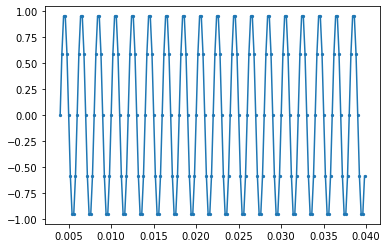

In [138]:
fs = 5000
f0 = 500

x = np.arange(0, 200/fs, 1/fs)
y = np.sin(2*np.pi*(f0*x)**1.)
x = x[20:]; y = y[20:]

plt.plot(x,y)
plt.scatter(x,y,s=5)

In [139]:

def __make_spectra_MT(sig_in, fs, method="unity"):
    
    from spectrum import data_cosine, dpss, pmtm
    
#     tt = np.arange(samples_to_fit/2, len(time)-samples_to_fit/2, shift_samples) 

    window_length = len(sig_in)
    time_half_bandwidth = 3
    first_k_slepian_sequences = 2
    
    [tapers, eigen] = dpss(window_length, time_half_bandwidth, first_k_slepian_sequences)
    
    specs = []    

    if method == 'unity':

        ## call pmtm function of spectrum library
        sk_complex, weights, eigen = pmtm(sig_in, e=eigen, v=tapers, show=False, method='unity')

        ## right scaling
        sk = abs(sk_complex)**2

        ## redefine weithgts, since wrong in dimension
        weights = np.transpose(np.ones(np.shape(sk)))

        ## multiply output sk matrix and weights matrix and average rows 
        out = np.mean(np.matmul(weights,sk), axis=0)            


    elif method == 'adapt':

        ## call pmtm function of spectrum library
        sk_complex, weights, eigen = pmtm(sig_in, e=eigen, v=tapers, show=False, method='adapt')

        ## multiply output sk matrix and weights matrix and average rows 

        ## right scaling            
        sk = abs(sk_complex)**2

        ## multiply output sk matrix and weights matrix and average rows             
        out = np.mean(np.matmul(weights,sk), axis=1)

    ## return one-sided spectrum
    out = out[:window_length//2]
        
    ##gather outputs
    specs.append(out)
#     del out
    
    ## generate frequency axius
    freqs = np.linspace(0, 0.5*fs, len(specs[0]))         
    
    return specs, freqs


758.42696629213481

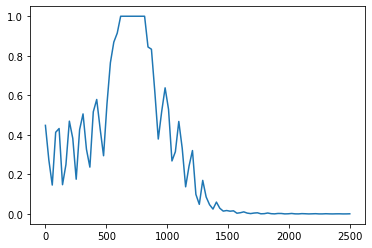

In [140]:


specs, freqs = __make_spectra_MT(y, fs, method="adapt")

plt.plot(freqs, specs[0])

freqs[specs[0].argmax()]

In [141]:
# from scipy import optimize

# fs = 10
# f0 = 0.1
# y0 = 2
# x = np.arange(0, 200/fs, 1/fs)
# y = np.sin(2*np.pi*(f0*x)**1.3)
# x = x[20:]; y = y[20:]


# time = x
# samples_to_fit = 6
# shift_samples  = 2

# ## get delta t
# if abs((time[2]-time[1]) - (time[-2]-time[-3])) > 1e-10:
#     print("problem with sampling interval!")
# else:
#     dt = (time[2]-time[1])


# amps=[]
# freq=[]

# hs = int(samples_to_fit/2)

# ## create time refernce 
# tt = np.arange(samples_to_fit/2, len(time)-samples_to_fit/2, shift_samples) 



# ## hanning tapered sine function 
# def func(x, a, b): 
#     return a * np.sin(2*np.pi* b * x) * np.hanning(len(x) )

# win = np.hanning(samples_to_fit)

# for idx in tqdm(tt):
#     idx = int(idx)
    
    
#     ## startvalues for fitting
#     a0 = 2.0
#     b0 = 1.9
#     b_set = 0.1


#     while abs(b0-b_set) > 0.05:
#         b0 = b_set
#         params, params_covariance = optimize.curve_fit(func, time[idx-hs:idx+hs], 
#                                                        win*y[idx-hs:idx+hs],
#                                                        p0=[a0, b0]
#                                                       )
#         b_set = params[1]


#     amps.append(params[0])
#     freq.append(params[1])

# ## convert lists to arrays
# amps = np.array(amps)
# freq = np.array(freq)

# tt=tt/fs

# plt.plot(x,y)
# plt.plot(tt, amps*np.sin(2*np.pi*freq*tt))


In [ ]:

# def __resample_digital_signal(signal_in, fs, sampling_factor, taper=False):

#     ''' 
#     up-samping of the simulated digital signal 
    
#     sig_in   = input signal
#     fs       = sampling frequency of digital signal
#     fac      = sampling factor (2 = double)
#     taper    = True/False , to either taper or not taper output
    
#     '''
    

# #     def butter_bandpass(lowcut, highcut, fs, order=5):
# #         nyq = 0.5 * fs
# #         low = lowcut / nyq
# #         high = highcut / nyq
# #         b, a = butter(order, [low, high], btype='band')
# #         return b, a


# #     def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
# #         b, a = butter_bandpass(lowcut, highcut, fs, order=order)
# #         y = lfilter(b, a, data)
# #         return y


#     def resampling(sig_in, factor, fs, case):

#         if case == 1:
#             sig_out = resample(sig_in, len(sig_in)*factor)

#         elif case == 2:
#             sig = list(sig_in); i=0

#             while i < len(sig):
#                 sig.insert(i, 0.0)
#                 i += 2
#             sig_out = np.array(sig)

#         t_out = np.arange(0,len(sig_in)/fs,1/(fs*factor))

#         return  (sig_out, t_out)



#     #sig_dig_fil_res, tt_res = resampling(sig_dig_fil,2,fs,2)
#     signal_out, time_out = resampling(signal_in, sampling_factor, fs, case=1)

#     if taper:
#         signal_out = np.hanning(signal_out.size) * sig_nal_out
#         #signal_out = butter_bandpass_filter(sig_dig_res_tap,0.1,100,fs,4)
   
    
#     return signal_out, time_out
    